# Predicting Popularity: Using Text and Content Analysis to Examine Shared Characteristics of Popular Posts on Twitter

### A CS109 Final Project by Belinda Zeng, Roseanne Feng, Yuqi Hou, and Zahra Mahmood

![caption](https://studentshare.net/content/wp-content/uploads/2015/05/53a0e7d640b31_-_unknown-3-51047042.png)

## Background and Motivation

Twitter (https://twitter.com) is social network, real-time news media service, and micro-blogging service where users can use text, photos, and videos to express moments or ideas in 140-characters or less. These 140-character messages are called "tweets.” According to Twitter’s website, millions of tweets are shared in real time, every day. Registered users can read and post tweets, favorite other people’s tweets, retweet other people’s posts, favorite tweets, and follow other accounts. Unregistered users can read tweets from public accounts. 

In today's day and age of Twitter, popularity is measured in hearts, retweets, follows, and follow-backs. What posts get popular over time? What seems to resonate most with people? Do positive or negative sentiments invite more engagement? In this project, we use Twitter's publically available archive of content to  like to examine some of the shared characteristics of popular posts, including length of post, visual content, positivity, negativity.

## Related Work

Our idea came from a desire to understand how movements such as #BlackLivesMatter and #Ferguson begin on Twitter as well as a general desire to know what makes a post popular. We chose to focus on Tweets on an individual level and to use natural language processing to be able to understand and predict what makes posts popular.

One paper that is related to our work is a paper from Cornell titled, [The effect of wording on message propagation: Topic- and author-controlled natural experiments on Twitter](https://chenhaot.com/pages/wording-for-propagation.html), which compaired pairs of tweets containing the same url and written by the same user but employing different wording to see which version attracted more retweets. Twitter itself has published research on [What fuels a Tweet’s engagement?](https://blog.twitter.com/2014/what-fuels-a-tweets-engagement) Their research found that adding video, links and photos all result in an increase in the number of retweets and even breaking down those results by industry. Inspired by previous research, we sought to include sentiment analysis in our understanding of what made a Tweet popular. 

## Initial Questions

1. How does the distribution of retweets and hearts vary for a post depending on the time of day when tweet is created?
2. How does positive and negative sentiment affect popularity? 
3. What Tweets do we think will become popular?

## Data

This data is publicly available via the Twitter Static API that gets queries based on specific parameters. We limited the data set to look at tweets within a specified period of time. We are storing the data in CSV files for now. To reduce file-sizes, we will try to have multiple CSVs so that we don't load too much data into memory. If data exceeds computer memory, we will consider AWS/SQL database alternatives. 

### Scraping

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import csv

In [2]:
# !pip install tweepy

Set up oauth and a app on Twitter (to getthe consumer key & secret and access token and secret)

In [7]:
# great resource where I got all this 
# http://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/

import tweepy
import json
from tweepy import OAuthHandler


consumer_key = 'lun6TR6KpaISisFdGnQ5Eo8v5'
consumer_secret = 'hmwEtnfvTfI6CljEKKtIGjahG4NcFQvLBXhOnPyFHmAqNZ9fVV'
access_token = '3004335028-UKSgKFDbaBLNWTzXQFrBRDwVOKo0JR475KYY3LW'
access_secret = 'pA6MeW4NYsv3tL0MRvjI1oBqdUZc0os11gesdNVkeLpX2'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

Our initial approach is to create a random sample that consists of 1% of tweets. This involves using tweepy and the sample call from the Twitter API.

```python
# final, final version 

from tweepy import Stream
from tweepy.streaming import StreamListener

# get retweet status
def try_retweet(status, attribute):
    try:
        if getattr(status, attribute):
            return True
    except AttributeError:
        return None

# function that tries to get attribute from object
def try_get(status, attribute):
    try:
        return getattr(status, attribute).encode('utf-8')
    except AttributeError:
        return None

# open csv file
csvFile = open('smallsample.csv', 'a')

# create csv writer
csvWriter = csv.writer(csvFile)

class MyListener(StreamListener):
    
    def on_status(self, status):
        try:
            # save relevant components of the tweet
            
            # get and sanitize hashtags 
            hashtags = status.entities['hashtags']
            hashtag_list = []
            for el in hashtags:
                hashtag_list.append(el['text'])
            hashtag_count = len(hashtag_list)
            
            # get and sanitize urls
            urls = status.entities['urls']
            url_list = []
            for el in urls:
                url_list.append(el['url'])
            url_count = len(url_list)
            
            # get and sanitize user_mentions
            user_mentions = status.entities['user_mentions']
            mention_list = []
            for el in user_mentions:
                mention_list.append(el['screen_name'])
            mention_count = len(mention_list)
            # save it all as a tweet
            tweet = [status.created_at, status.text.encode('utf-8'), status.place, status.lang, status.coordinates, 
              hashtag_list, url_list, mention_list, 
              hashtag_count, url_count, mention_count, 
              try_get(status, 'possibly_sensitive'),
              status.favorite_count, status.favorited, status.retweet_count, status.retweeted, 
              try_retweet(status,'retweeted_status'), 
              try_get(status.user, 'statuses_count'), 
              try_get(status.user, 'favourites_count'), 
              try_get(status.user, 'followers_count'),
              try_get(status.user, 'description'),
              try_get(status.user, 'location')]
            
            # write to csv
            csvWriter.writerow(tweet)
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True
    
    # tell us if there's an error
    def on_error(self, status):
        print(status)
        return True

twitter_stream = Stream(auth, MyListener())
twitter_stream.sample()
```

From this point on, analysis will be done previously scraped tweets, and there is no need to run the above code block.

In [2]:
tweetdf_small=pd.read_csv("tempdata/smallsample.csv", names=["created_at", "text", "place", "lang", "coordinates",
                                       "hashtags", "urls", "user_mentions", 
                                       "hashtag_count", "url_count", "mention_count",
                                       "possibly_sensitive", 
                                       "favorite_count", "favorited", "retweet_count", "retweeted",
                                       "retweeted_status", "user_statuses_count", "user_favorites_count",
                                       "user_follower_count", "user_description", "user_location"])
tweetdf_small.head(10)

,created_at,text,place,lang,coordinates,hashtags,urls,user_mentions,hashtag_count,url_count,mention_count,possibly_sensitive,favorite_count,favorited,retweet_count,retweeted,retweeted_status,user_statuses_count,user_favorites_count,user_follower_count,user_description,user_location
0,2015-11-24 21:24:41,RT @AcWgst: Reminds me of the fairytail~♡ Matt...,NaN,en,NaN,[],[],[u'AcWgst'],0,0,1,NaN,0,False,0,False,True,NaN,NaN,NaN,"I love music, art, history, current events, WD...",California
1,2015-11-24 21:24:41,ドラゴンスラッシュってスマホゲーらしいのだけれどスクリーンショットだけを見てるとほんとヴァニ...,NaN,ja,NaN,[],[],[],0,0,0,NaN,0,False,0,False,NaN,NaN,NaN,NaN,NaN,県北
2,2015-11-24 21:24:41,やられたでや\n石神さん状態w,NaN,ja,NaN,[],[],[],0,0,0,NaN,0,False,0,False,NaN,NaN,NaN,NaN,味楽一条通り店。時々有明 故に我はエロティカセブン,土田 みさと
3,2015-11-24 21:24:41,#UKVOTY1D #MTVStars One Direction (MARO) Nicki...,NaN,sl,NaN,"[u'UKVOTY1D', u'MTVStars']",[],[],2,0,0,NaN,0,False,0,False,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-11-24 21:24:41,"RT @WhylmSingle: I WILL LOOK FOR YOU, I WILL F...",NaN,en,NaN,[],[],[u'WhylmSingle'],0,0,1,NaN,0,False,0,False,True,NaN,NaN,NaN,"Electronic music producer/vocalist, PR/AR mana...","Miami, FL"
5,2015-11-24 21:24:41,RT @higeorgeshelley: If u guys vote enough ton...,NaN,en,NaN,[],[],[u'higeorgeshelley'],0,0,1,NaN,0,False,0,False,True,NaN,NaN,NaN,I wanna runaway...,my own little world
6,2015-11-24 21:24:41,I Been Sleeping On @gilliedakid He 🔥,NaN,en,NaN,[],[],[u'gilliedakid'],0,0,1,NaN,0,False,0,False,NaN,NaN,NaN,NaN,FMOI @quicktriggap Blessed Basketball Bigman S...,Philly
7,2015-11-24 21:24:41,RT @awwmyloueh: @izaynie93 I'm proud of you!,NaN,en,NaN,[],[],"[u'awwmyloueh', u'izaynie93']",0,0,2,NaN,0,False,0,False,True,NaN,NaN,NaN,sometimes I add too little milk to my coffee a...,zquad ◡̈
8,2015-11-24 21:24:41,RT @CaronPeirson: @CleanDropMobile Let's clink...,NaN,en,NaN,[u'DigiBlogChat'],[],"[u'CaronPeirson', u'CleanDropMobile']",1,0,2,NaN,0,False,0,False,True,NaN,NaN,NaN,CleanDrop a mobile app for #foodies who deman...,USA
9,2015-11-24 21:24:41,RT @JosAntonioNez: Dentro de 1 mes todo el mun...,NaN,es,NaN,[],[],[u'JosAntonioNez'],0,0,1,NaN,0,False,0,False,True,NaN,NaN,NaN,Del 97. Hermana de la Macarena. Auxiliar de En...,NaN


In [3]:
tweetdf_small.shape

(52766, 22)

As we can see however, the retweet count and favorite count are always 0. This is because we're using the live streaming API and as a result, we're scraping the tweets as they are tweeted. At this point, all the tweets have retweet count 0 and favorite count 0 since they were literally just posted! That is, unless the tweet posted is actually a retweet...

In [18]:
# just found this bug with retweet_count, looking into why this might be the case
tweetdf_missing = tweetdf_small[tweetdf_small['retweet_count'] != 0]

In [19]:
tweetdf_missing.shape

(0, 22)

#### Getting original retweets

The following function updates the way we use the tweepy streaming API. We first detect if the tweet we're looking at is actually a retweet of something. If so, we then get the original tweet and save that to our csv.

```python
# only save information for retweets

from tweepy import Stream
from tweepy.streaming import StreamListener

# get retweet status
def try_retweet(status, attribute):
    try:
        if getattr(status, attribute):
            return True
    except AttributeError:
        return None

# get country status
def try_country(status, attribute):
    if getattr(status, attribute) != None:
        place = getattr(status, attribute)
        return place.country
    return None

# get city status
def try_city(status, attribute):
    if getattr(status, attribute) != None:
        place = getattr(status, attribute)
        return place.full_name
    return None

# function that tries to get attribute from object
def try_get(status, attribute):
    try:
        return getattr(status, attribute).encode('utf-8')
    except AttributeError:
        return None

# open csv file
csvFile = open('originalsample.csv', 'a')

# create csv writer
csvWriter = csv.writer(csvFile)

class MyListener(StreamListener):
    
    def on_status(self, status):
        try:
            # if this represents a retweet
            if try_retweet(status,'retweeted_status'):
                status = status.retweeted_status
                
                # get and sanitize hashtags 
                hashtags = status.entities['hashtags']
                hashtag_list = []
                for el in hashtags:
                    hashtag_list.append(el['text'])
                hashtag_count = len(hashtag_list)

                # get and sanitize urls
                urls = status.entities['urls']
                url_list = []
                for el in urls:
                    url_list.append(el['url'])
                url_count = len(url_list)

                # get and sanitize user_mentions
                user_mentions = status.entities['user_mentions']
                mention_list = []
                for el in user_mentions:
                    mention_list.append(el['screen_name'])
                mention_count = len(mention_list)
                
                # save it all as a tweet
                tweet = [status.id, status.created_at, try_country(status, 'place'), try_city(status, 'place'), status.text.encode('utf-8'), status.lang,
                  hashtag_list, url_list, mention_list, 
                  hashtag_count, url_count, mention_count, 
                  try_get(status, 'possibly_sensitive'),
                  status.favorite_count, status.favorited, status.retweet_count, status.retweeted, 
                  status.user.statuses_count, 
                  status.user.favourites_count, 
                  status.user.followers_count,
                  try_get(status.user, 'description'),
                  try_get(status.user, 'location'),
                  try_get(status.user, 'time_zone')]
            
                # write to csv
                csvWriter.writerow(tweet)
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True
    
    # tell us if there's an error
    def on_error(self, status):
        print(status)
        return True

twitter_stream = Stream(auth, MyListener())
twitter_stream.sample()
```

Now we read into pandas.

In [3]:
tweetdf=pd.read_csv("tempdata/originalsample.csv", names=["id", "created_at", "country", "city", "text", "lang",
                                       "hashtags", "urls", "user_mentions", 
                                       "hashtag_count", "url_count", "mention_count",
                                       "possibly_sensitive", 
                                       "favorite_count", "favorited", "retweet_count", "retweeted",
                                       "user_statuses_count", "user_favorites_count",
                                       "user_follower_count", "user_description", "user_location", "user_timezone"])
tweetdf.head(15)

,id,created_at,country,city,text,lang,hashtags,urls,user_mentions,hashtag_count,url_count,mention_count,possibly_sensitive,favorite_count,favorited,retweet_count,retweeted,user_statuses_count,user_favorites_count,user_follower_count,user_description,user_location,user_timezone
0,669227044996124673,2015-11-24 18:52:15,NaN,NaN,Yo 💁🏼💟👌🏼 https://t.co/xLMaOl9QD4,und,[],[],[],0,0,0,NaN,270,False,288,False,10726,18927,24429,NaN,"Yucatán, México",Mexico City
1,669328402453626880,2015-11-25 01:35:01,NaN,NaN,読者が生産者に会いに行く!『北海道食べる通信』初の読者ツアー開催 – 北海道ファンマガジン ...,ja,[],[u'https://t.co/w4GkSYLhoz'],[],0,1,0,NaN,1,False,1,False,10176,241,1783,手稲駅南口直結徒歩１分 ハートビル法認定バリアフリーホテル 札幌市福祉のまちづくり条例適合ホ...,北海道札幌市手稲区手稲本町1条4丁目1番５号,Sapporo
2,669335707505201152,2015-11-25 02:04:02,NaN,NaN,"Not 1 shot, not 2 but 16. 16 tax payer purchas...",en,"[u'LaquanMcDonald', u'sickofthesehashtags']",[],[],2,0,0,NaN,25,False,23,False,15349,1590,69865,"Sideways Slipper, ALEKESAM",The Universe,Pacific Time (US & Canada)
3,668550084976578560,2015-11-22 22:02:15,NaN,NaN,#comeeeheree @DooleyFunnyAf !! Had to get yo a...,en,[u'comeeeheree'],[],[u'DooleyFunnyAf'],1,0,1,NaN,24,False,28,False,11124,15210,4085,$quad Original | https://soundcloud.com/vanteb...,NaN,Eastern Time (US & Canada)
4,669304504513380352,2015-11-25 00:00:03,NaN,NaN,Best #Thanksgiving memory? @KnucklePuckIL shar...,en,[u'Thanksgiving'],[u'https://t.co/IYC1jEOTeC'],[u'KnucklePuckIL'],1,1,1,NaN,158,False,33,False,52246,4509,526915,"The nation’s leading voice on underground, alt...","Cleveland, Ohio",Eastern Time (US & Canada)
5,669178757417009152,2015-11-24 15:40:23,NaN,NaN,Muhammad kenapa handsome sangat 😍😂 https://t...,in,[],[],[],0,0,0,NaN,91,False,173,False,58643,8317,733,spread positivity ✨,MY,Kuala Lumpur
6,669348536081850369,2015-11-25 02:55:01,NaN,NaN,rt for 5sos #MTVStars 5 Seconds of Summer,en,[u'MTVStars'],[],[],1,0,0,NaN,3,False,21,False,9816,3,3299,appreciating Michael mostly *ଘ(੭*ˊᵕˋ)੭* ੈ✩‧₊˚ ...,(Liv • Blain• Ant),Eastern Time (US & Canada)
7,669335559425417216,2015-11-25 02:03:27,NaN,NaN,"""Why didn't you do your homework over the holi...",en,[],[],[],0,0,0,NaN,283,False,218,False,53293,341,476765,just stahp. \r\n\r\nyou probably just ignore m...,NaN,Eastern Time (US & Canada)
8,669339114974478336,2015-11-25 02:17:35,NaN,NaN,I think one of my favorite feelings is laughin...,en,[],[],[],0,0,0,NaN,5,False,1,False,10140,6619,953,"⊱✿LIVE. .Like there's no midnight! ✿⊰ idfwu, t...",NaN,NaN
9,669348858418192384,2015-11-25 02:56:18,NaN,NaN,하루치하\r\n같이 팝시다\r\n#프로듀서_트친소 https://t.co/0ARAt...,ko,[u'\ud504\ub85c\ub4c0\uc11c_\ud2b8\uce5c\uc18c'],[],[],1,0,0,NaN,0,False,7,False,22768,1295,159,"아이마스와 하루치하 파는 잉여 유하치 / 쿄애니, 중력폭포, 디즈니 픽사도 파요!!...",NaN,Pacific Time (US & Canada)


In [4]:
tweetdf.shape

(114509, 23)

## Data wrangling

#### Filter for language

In [5]:
df_filtered = tweetdf[tweetdf['lang'] == 'en']

In [6]:
df_filtered.shape

(57079, 23)

####Filter for unique tweet ids

In [7]:
df_filtered.drop_duplicates(subset='id', take_last=True)

,id,created_at,country,city,text,lang,hashtags,urls,user_mentions,hashtag_count,url_count,mention_count,possibly_sensitive,favorite_count,favorited,retweet_count,retweeted,user_statuses_count,user_favorites_count,user_follower_count,user_description,user_location,user_timezone
2,669335707505201152,2015-11-25 02:04:02,NaN,NaN,"Not 1 shot, not 2 but 16. 16 tax payer purchas...",en,"[u'LaquanMcDonald', u'sickofthesehashtags']",[],[],2,0,0,NaN,25,False,23,False,15349,1590,69865,"Sideways Slipper, ALEKESAM",The Universe,Pacific Time (US & Canada)
3,668550084976578560,2015-11-22 22:02:15,NaN,NaN,#comeeeheree @DooleyFunnyAf !! Had to get yo a...,en,[u'comeeeheree'],[],[u'DooleyFunnyAf'],1,0,1,NaN,24,False,28,False,11124,15210,4085,$quad Original | https://soundcloud.com/vanteb...,NaN,Eastern Time (US & Canada)
4,669304504513380352,2015-11-25 00:00:03,NaN,NaN,Best #Thanksgiving memory? @KnucklePuckIL shar...,en,[u'Thanksgiving'],[u'https://t.co/IYC1jEOTeC'],[u'KnucklePuckIL'],1,1,1,NaN,158,False,33,False,52246,4509,526915,"The nation’s leading voice on underground, alt...","Cleveland, Ohio",Eastern Time (US & Canada)
6,669348536081850369,2015-11-25 02:55:01,NaN,NaN,rt for 5sos #MTVStars 5 Seconds of Summer,en,[u'MTVStars'],[],[],1,0,0,NaN,3,False,21,False,9816,3,3299,appreciating Michael mostly *ଘ(੭*ˊᵕˋ)੭* ੈ✩‧₊˚ ...,(Liv • Blain• Ant),Eastern Time (US & Canada)
8,669339114974478336,2015-11-25 02:17:35,NaN,NaN,I think one of my favorite feelings is laughin...,en,[],[],[],0,0,0,NaN,5,False,1,False,10140,6619,953,"⊱✿LIVE. .Like there's no midnight! ✿⊰ idfwu, t...",NaN,NaN
11,668717375622021120,2015-11-23 09:07:01,NaN,NaN,Me: he told me to calm down\r\n\r\n911: ma'am ...,en,[],[],[],0,0,0,NaN,118,False,76,False,63011,76098,10895,wife of 1 mother of 6 https://twitter.com/sear...,NaN,Pacific Time (US & Canada)
17,669346377789341696,2015-11-25 02:46:26,Canada,"Toronto, Ontario",finding the perfect prom dress is so fucking d...,en,[],[],[],0,0,0,NaN,0,False,1,False,5351,3782,222,a freak and a friend too // love u @arnaudm_19...,"Toronto, Ontario",NaN
31,667168377744416768,2015-11-19 02:31:51,NaN,NaN,Holy shit I never noticed that https://t.co/ZP...,en,[],[],[],0,0,0,NaN,570,False,5764,False,25913,18275,2026,//O2L forever// I'll never forget you ~ B.B //,4/5 +more,NaN
32,669010936842362880,2015-11-24 04:33:31,NaN,NaN,That bomb bomb lol 😛💦💦💦,en,[],[],[],0,0,0,NaN,2,False,1,False,23632,1677,664,NaN,NaN,Quito
41,668977048103223296,2015-11-24 02:18:51,NaN,NaN,.@OHSPatsFootball gets rematch with @Maryville...,en,[],"[u'https://t.co/3fRuw5qRYN', u'https://t.co/ak...","[u'OHSPatsFootball', u'MaryvilleHigh']",0,2,2,NaN,6,False,8,False,105016,8179,9488,High school sports writer at The (Murfreesboro...,"Murfreesboro, Tennessee",Central Time (US & Canada)


In [8]:
df_filtered.shape

(57079, 23)

#### Popularity Score

In [9]:
popularity = [retweets + favs for retweets, favs in zip(df_filtered.retweet_count, df_filtered.favorite_count)]

#### Add popularity column

In [10]:
# df_filtered['popularity']=popularity
df_filtered.loc[:,'popularity']=popularity

c:\Anaconda\lib\site-packages\pandas\core\indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\Anaconda\lib\site-packages\pandas\core\indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
df_filtered.shape

(57079, 24)

In [12]:
dftouse = df_filtered.reset_index()
dftouse.head()

,index,id,created_at,country,city,text,lang,hashtags,urls,user_mentions,hashtag_count,url_count,mention_count,possibly_sensitive,favorite_count,favorited,retweet_count,retweeted,user_statuses_count,user_favorites_count,user_follower_count,user_description,user_location,user_timezone,popularity
0,2,669335707505201152,2015-11-25 02:04:02,NaN,NaN,"Not 1 shot, not 2 but 16. 16 tax payer purchas...",en,"[u'LaquanMcDonald', u'sickofthesehashtags']",[],[],2,0,0,NaN,25,False,23,False,15349,1590,69865,"Sideways Slipper, ALEKESAM",The Universe,Pacific Time (US & Canada),48
1,3,668550084976578560,2015-11-22 22:02:15,NaN,NaN,#comeeeheree @DooleyFunnyAf !! Had to get yo a...,en,[u'comeeeheree'],[],[u'DooleyFunnyAf'],1,0,1,NaN,24,False,28,False,11124,15210,4085,$quad Original | https://soundcloud.com/vanteb...,NaN,Eastern Time (US & Canada),52
2,4,669304504513380352,2015-11-25 00:00:03,NaN,NaN,Best #Thanksgiving memory? @KnucklePuckIL shar...,en,[u'Thanksgiving'],[u'https://t.co/IYC1jEOTeC'],[u'KnucklePuckIL'],1,1,1,NaN,158,False,33,False,52246,4509,526915,"The nation’s leading voice on underground, alt...","Cleveland, Ohio",Eastern Time (US & Canada),191
3,6,669348536081850369,2015-11-25 02:55:01,NaN,NaN,rt for 5sos #MTVStars 5 Seconds of Summer,en,[u'MTVStars'],[],[],1,0,0,NaN,3,False,21,False,9816,3,3299,appreciating Michael mostly *ଘ(੭*ˊᵕˋ)੭* ੈ✩‧₊˚ ...,(Liv • Blain• Ant),Eastern Time (US & Canada),24
4,7,669335559425417216,2015-11-25 02:03:27,NaN,NaN,"""Why didn't you do your homework over the holi...",en,[],[],[],0,0,0,NaN,283,False,218,False,53293,341,476765,just stahp. \r\n\r\nyou probably just ignore m...,NaN,Eastern Time (US & Canada),501


## Exploratory Analysis

After scraping the tweets from the Twitter API, we can use that data to build a feature list that we use to predict how popular an individual tweet is, measured by a composite score based on the amount of retweets and hearts. We will also use metadata to help us analyze trends in the data, for example if there is a correlation between time of day and retweets.

In [21]:
from scipy.stats.stats import pearsonr

### Update: 11/30 - 12/1 (Yuqi)

Initial exploratory analysis regarding popularity score and hashtags done. It seems like we should rethink our current formula for popularity because the histogram gives extreme strange results and the max score is really high. Need to look into why that might be. 

All of the correlations that were done between popularity score and other factors came up significant. Could this be due to the large dataset that we are using? Should we be worried about things being labeled as significant not because it actually is significant but because there is so much data that small variations become significant?

Also, noticed that some tweets are longer than 140 characters, and I'm not sure why that is either. Further data wrangling probably needed. 

### Popularity Score Analysis

#### Rethink how popularity is scored? ##
Huge standard deviation and extreme ranges suggest that we may need to rethink how we score popularity...

In [22]:
dftouse['popularity'].describe()

count      57079.000000
mean        4045.792078
std        28128.481508
min            1.000000
25%            8.000000
50%          152.000000
75%         1633.000000
max      2204783.000000
Name: popularity, dtype: float64

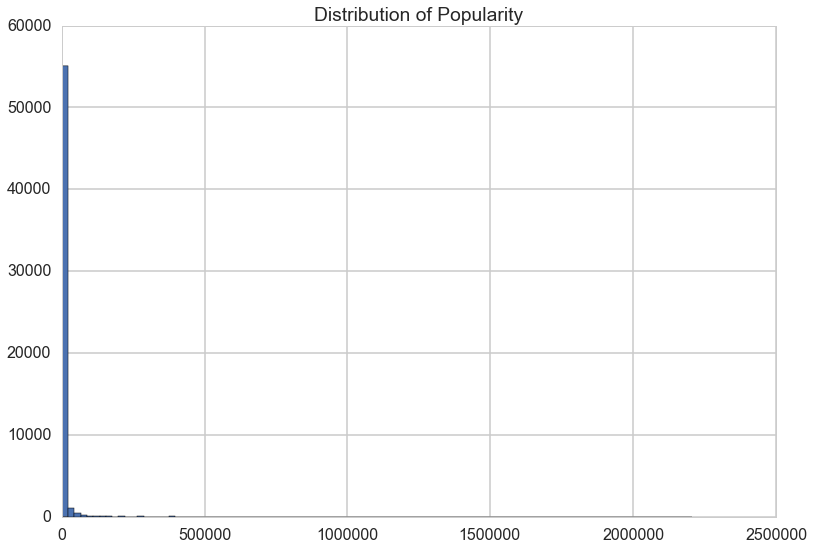

In [33]:
plt.hist(dftouse['popularity'],bins=100)
plt.title("Distribution of Popularity")
plt.show()

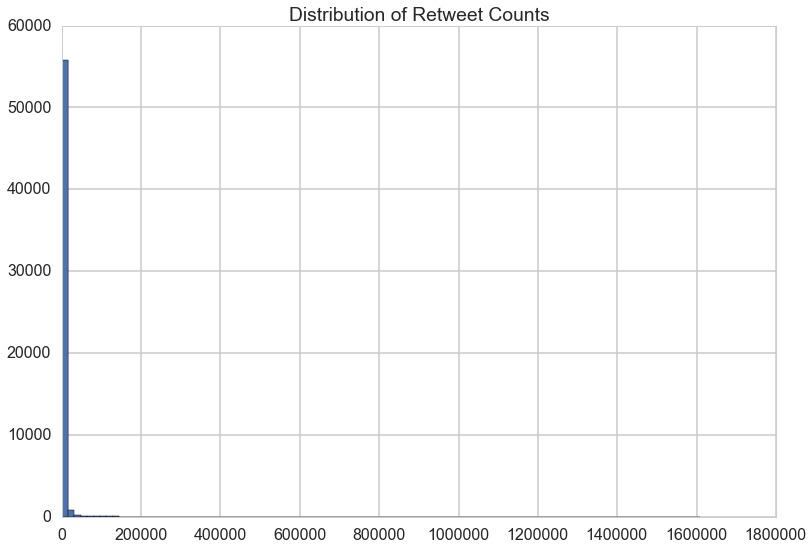

In [31]:
plt.hist(dftouse['retweet_count'],bins=100)
plt.title("Distribution of Retweet Counts")
plt.show()

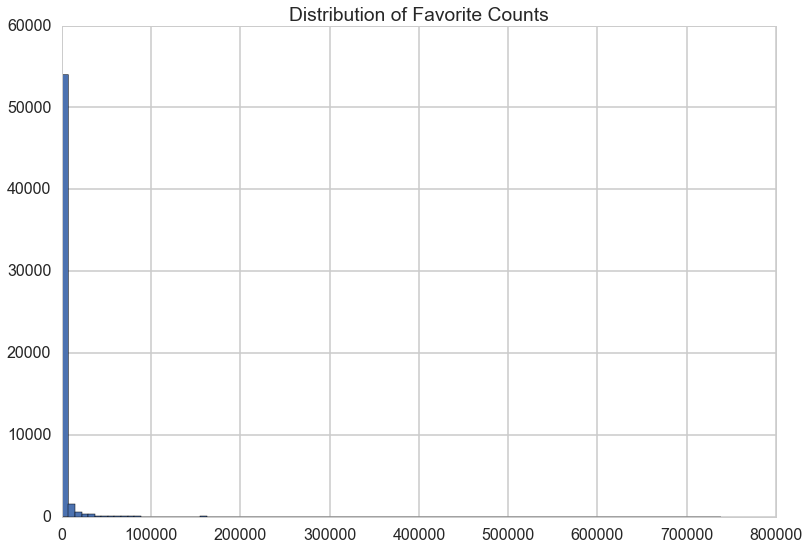

In [32]:
plt.hist(dftouse['favorite_count'],bins=100)
plt.title("Distribution of Favorite Counts")
plt.show()

### Hashtag Analysis

References: 
- http://stackoverflow.com/questions/1894269/convert-string-representation-of-list-to-list-in-python
- http://stackoverflow.com/questions/10201977/how-to-reverse-tuples-in-python
- http://stackoverflow.com/questions/13925251/python-bar-plot-from-list-of-tuples/34013980#34013980

#### What fraction of tweets in the sample use hashtags?

In [330]:
num_tags_per_tweet = dftouse['hashtag_count']
tags_per_tweet = np.array(num_tags_per_tweet)
tagfrac = float(len(tags_per_tweet[tags_per_tweet>0]))/float(len(tags_per_tweet))
print str(tagfrac)+" of tweets in the sample use one or more hashtags."

0.264458031851 of tweets in the sample use one or more hashtags.


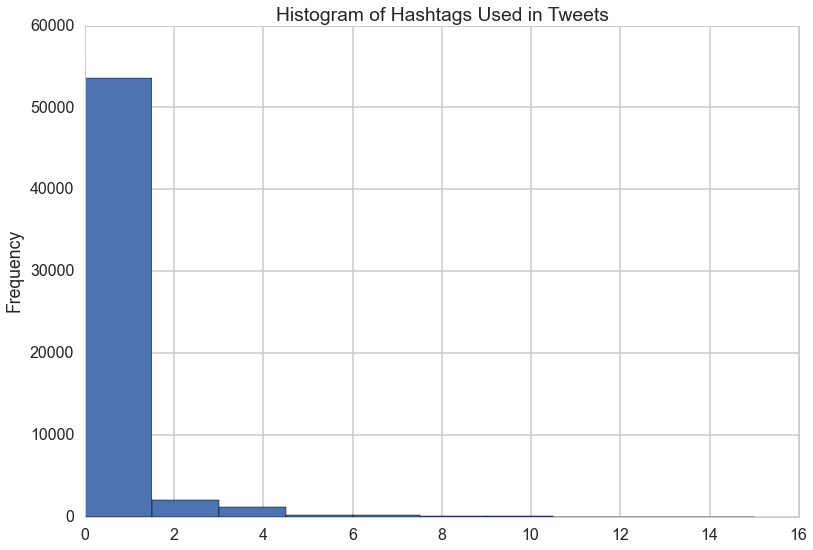

In [331]:
plt.hist(tags_per_tweet)
plt.ylabel('Frequency')
plt.title('Histogram of Hashtags Used in Tweets')
plt.show()

#### Top 10 hashtags 

First get a flattened list of all the hashtags used in the sample:

In [332]:
import ast
alltags=[] 
for i in dftouse['hashtags']: # grab all the tags and put them into a list
    tag = ast.literal_eval(i) # convert string representation of list to list 
    alltags.append(tag) 
hashtags = [item for sublist in alltags for item in sublist] # flatten out the nested list

Then make a bar plot of the 10 most commonly used hashtags:

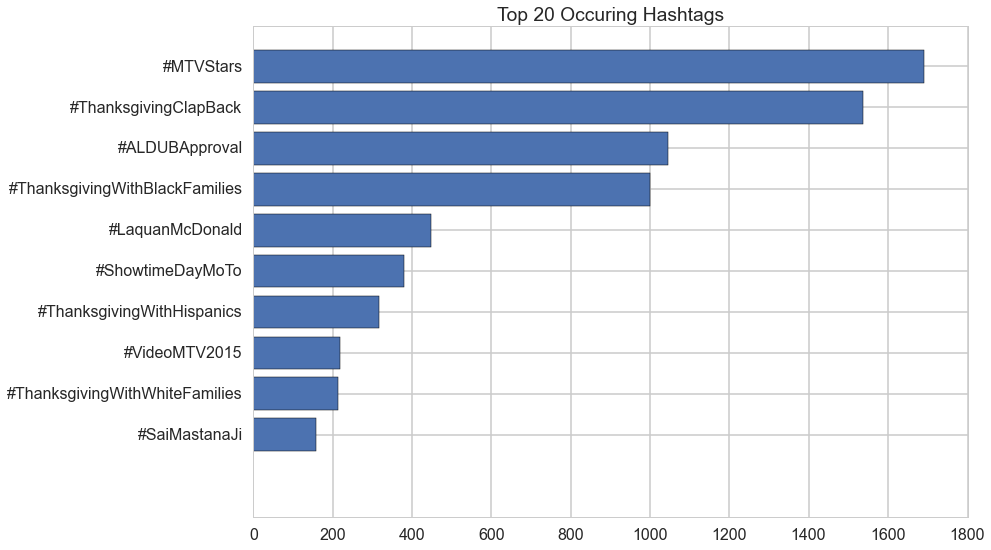

In [335]:
from collections import Counter
hashfreq = Counter(hashtags) # get the frequency of appearing hashtags
commontags = hashfreq.most_common(10) # save the top ten most common hashtags
taglabels = zip(*commontags)[0][::-1] # reverse the tuples to go from most frequent to least frequent 
hashtaglabels = ['#'+i for i in taglabels] # add a pound sign in front of each tag to make it clear that it's a hashtag
y_pos = np.arange(len(hashtaglabels)) 
usefreq = zip(*commontags)[1][::-1] # get the frequency part of the tuple
plt.barh(y_pos, usefreq, align='center') # plot horizontal barplot
plt.yticks(y_pos, hashtaglabels) 
plt.title('Top 20 Occuring Hashtags')
plt.show()

#### List of Hashtags Associated with Highest Popularity Score Tweets

(-0.040061431045992628, 1.0205935544150119e-21)


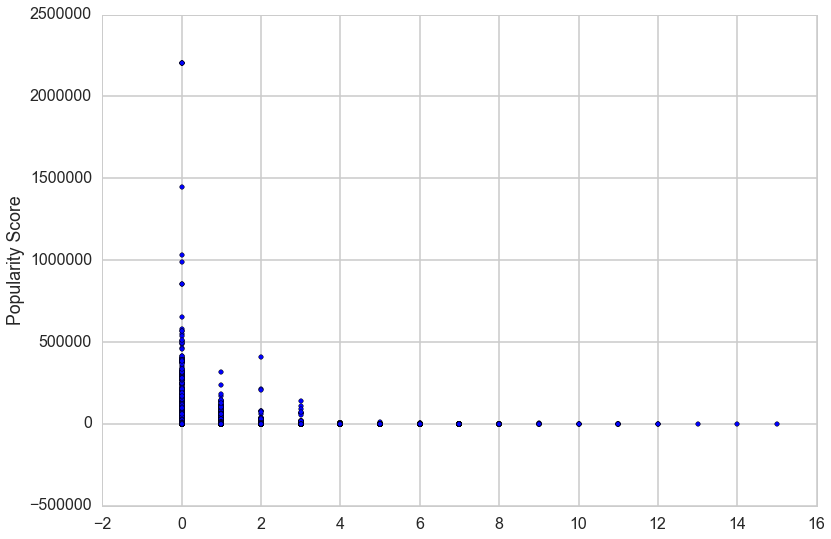

In [346]:
print pearsonr(dftouse['hashtag_count'],dftouse['popularity'])
plt.scatter(dftouse['hashtag_count'],dftouse['popularity'])
plt.ylabel('Popularity Score')
plt.show()

#### Correlation between length of tweet and popularity 

##### More data wrangling possibly needed: Why are some tweets longer than 140 characters? 

(-0.031540106002980857, 4.8081985095647666e-14)


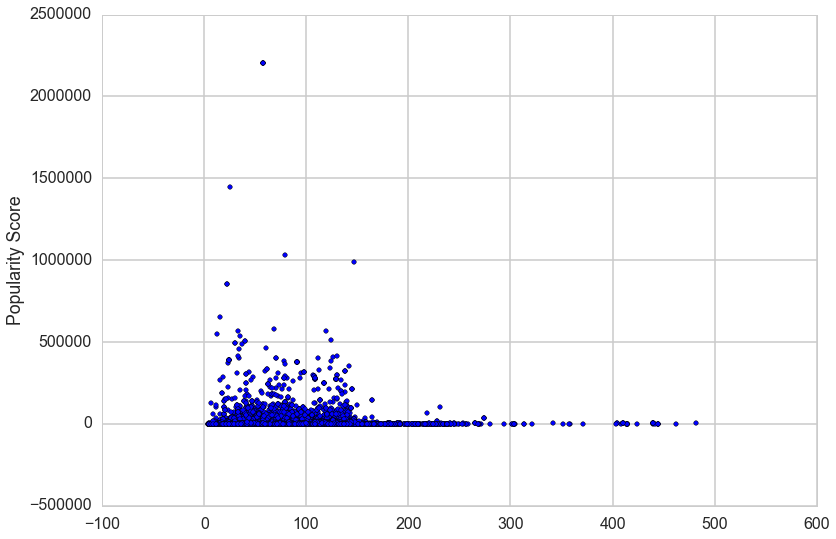

In [358]:
tweet_len = [len(text) for text in dftouse['text']]
print pearsonr(tweet_len,dftouse['popularity'])
plt.scatter(tweet_len,dftouse['popularity'])
plt.ylabel('Popularity Score')
plt.show()

#### Correlation between presence of image and popularity

Dataframe only has information about links, so not differentiating between images and other urls for now...

#### Correlation between presence of links and popularity

(-0.04422850622410171, 4.0325930413964576e-26)


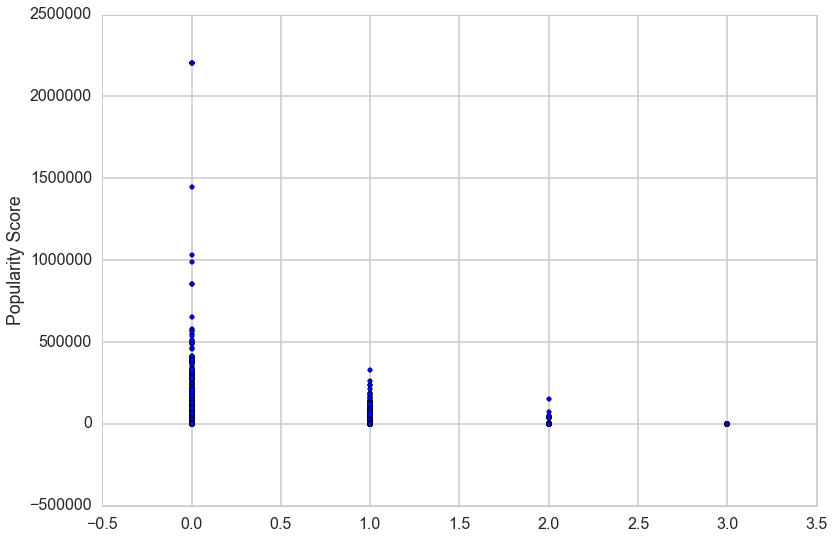

In [349]:
print pearsonr(dftouse['url_count'],dftouse['popularity'])
plt.scatter(dftouse['url_count'],dftouse['popularity'])
plt.ylabel('Popularity Score')
plt.show()

#### Correlation between user mentions and popularity

(-0.011617928076882581, 0.0055083571059131925)


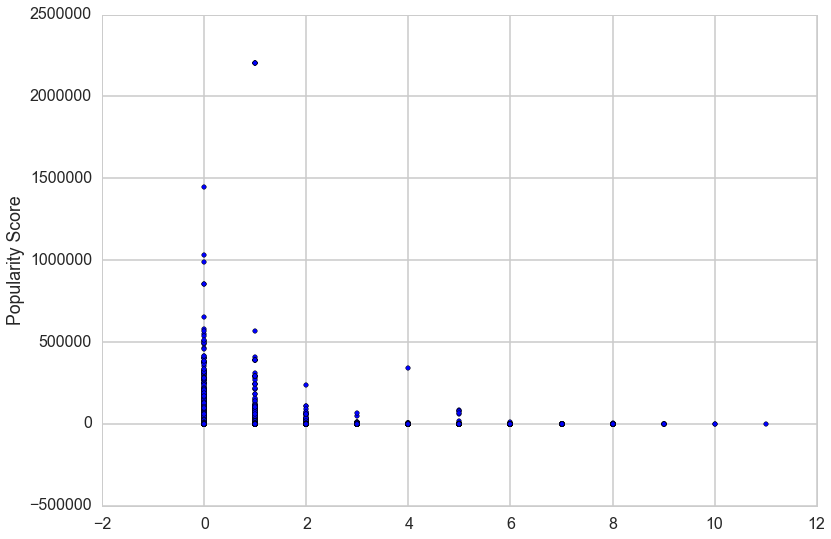

In [348]:
print pearsonr(dftouse['mention_count'],dftouse['popularity'])
plt.scatter(dftouse['mention_count'],dftouse['popularity'])
plt.ylabel('Popularity Score')
plt.show()

#### Correlation for number of retweets and hearts


(0.83853253023981866, 0.0)


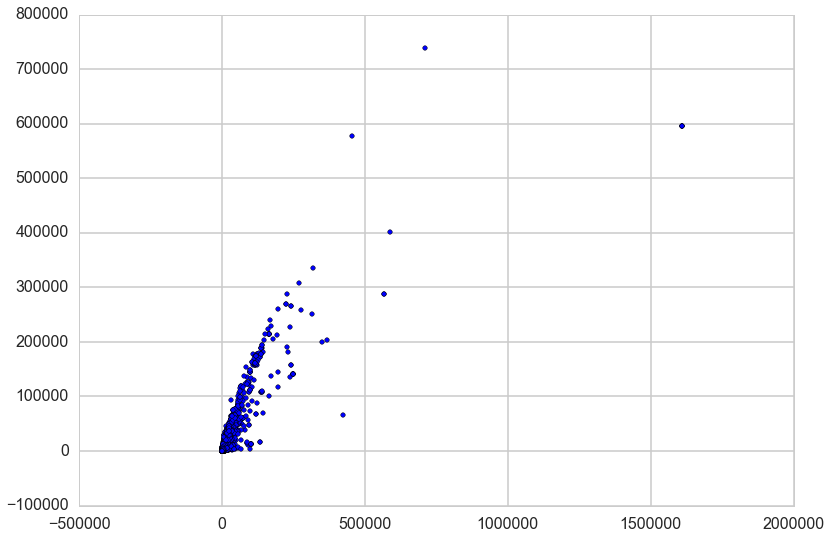

In [347]:
print pearsonr(dftouse['retweet_count'],dftouse['favorite_count'])
plt.scatter(dftouse['retweet_count'],dftouse['favorite_count'])
plt.show()

### Zahra Todo

#### Correlation between time of day and tweet popularity



#### The distribution of hearts & retweets over time


#### User's followers correlated with popularity

#### What's popular within the 10 most populous cities

#### What's most popular within each state

#### Trending tweets and trending lists affecting virality 

### Sentiment Analysis

#### Determining positive/negative words



Using sentiment lookup dictionaries, score tweets based on how positive/negative they are.

11/29 - Used a basic list of positive/negative words to begin with, no weights or other information beyond positive/negative. Appears to miss a bunch of tokens (1812/892606 found).

12/1 - Tried LabMT, using code provided. Rate is a lot better (7016/892606).

12/4 - Realized number of tokens (892606) was total tokens instead of unique tokens (83093). Still a lot but more tokens found than expected. LabMT is probably the better choice, though.

In [ ]:
#notes: Unicode in texts (probably emoticons? should we find a way to categorize those?)
#df_filtered['text']

#load dicts into lookup, map words to pos or neg value
#current dict: not sure where it's from?
#1812 of 83093 words in lookup.
lookup = {}
with open('positive.txt', 'r') as f:
    for line in f:
        word = line[:-1]
        lookup[word] = 1
with open('negative.txt', 'r') as f:
    for line in f:
        word = line[:-1]
        lookup[word] = -1

# uses LabMT for scoring, see http://neuro.imm.dtu.dk/wiki/LabMT
# 7016 of 83093 words in LabMT.
url = 'http://www.plosone.org/article/fetchSingleRepresentation.action?uri=info:doi/10.1371/journal.pone.0026752.s001'
labmt = pd.read_csv(url, skiprows=2, sep='\t', index_col=0)

In [14]:
import nltk
# you'll need to download NLTK resource: nltk.download()
# or use terminal: sudo python -m nltk.downloader -d /usr/local/share/nltk_data all

In [15]:
#text = reduce(lambda x,y: x+y, dftouse['text'].apply(lambda x: [x])) # list of strings, functionally identical to dftouse['text']
tweetstext = reduce(lambda x,y: x + '\n' + y, dftouse['text']) # string of concatenated texts, all

In [16]:
# filter out stop words, etc
# notice: tokenizer puts punctuation as their own tokens, ex. separates hashtags, etc.
tokens = nltk.word_tokenize(tweetstext.decode('utf-8','ignore'))

In [28]:
print "Number of tokens:", len(tokens)
fdist = nltk.FreqDist(tokens)
utokens = fdist.keys()
print "Unique tokens:", len(utokens)
print "Tokens that appear only once:", len(fdist.hapaxes())
#fdist.most_common(50)
inlookup = []
notfoundlookup = []
inlabmt = []
notfoundlabmt = []
for key in utokens:
    if key in lookup.keys():
        inlookup.append(key)
    else:
        notfoundlookup.append(key)
    if key in labmt.index:
        inlabmt.append(key)
    else:
        notfoundlabmt.append(key)
print "{} of {} words in lookup.".format(len(inlookup), len(utokens))
print inlookup[:10]

print "{} of {} words in LabMT.".format(len(inlabmt), len(utokens))
print inlabmt[:10]

Number of tokens: 892606
Unique tokens: 83093
Tokens that appear only once: 54968
1812 of 83093 words in lookup.
[u'foul', u'non-violent', u'uplifting', u'controversy', u'spotty', u'golden', u'insecurity', u'sinking', u'unjust', u'wrong']
7016 of 83093 words in LabMT.
[u'woods', u'hanging', u'foul', u'screaming', u'wednesday', u'errors', u'cooking', u'kids', u'controversy', u'rebel']


In [18]:
bigrams = dftouse['text'].apply(lambda x: list(nltk.bigrams(nltk.word_tokenize(x.decode('utf-8','ignore')))))
trigrams = dftouse['text'].apply(lambda x: list(nltk.trigrams(nltk.word_tokenize(x.decode('utf-8','ignore')))))
trigrams.head()

0    [(Not, 1, shot), (1, shot, ,), (shot, ,, not),...
1    [(#, comeeeheree, @), (comeeeheree, @, DooleyF...
2    [(Best, #, Thanksgiving), (#, Thanksgiving, me...
3    [(rt, for, 5sos), (for, 5sos, #), (5sos, #, MT...
4    [(``, Why, did), (Why, did, n't), (did, n't, y...
Name: text, dtype: object

In [20]:
# average of entire tweet over unigrams
average = labmt.happiness_average.mean()
happiness = (labmt.happiness_average - average).to_dict()
 
def score(text):
    words = text.split()
    return sum([happiness.get(word.lower(), 0.0) for word in words]) / len(words)

#dftouse['text'].apply(score).mean()
dftouse['sentiment'] = dftouse['text'].apply(score)
dftouse[['text','sentiment']].head()

,text,sentiment
0,"Not 1 shot, not 2 but 16. 16 tax payer purchas...",-0.508149
1,#comeeeheree @DooleyFunnyAf !! Had to get yo a...,-0.113670
2,Best #Thanksgiving memory? @KnucklePuckIL shar...,0.401190
3,rt for 5sos #MTVStars 5 Seconds of Summer,-0.044525
4,"""Why didn't you do your homework over the holi...",-0.230668


**12/4 - Roseanne**

Checking how our lookup and scoring is working.

Sentiment score ranges from approx. -3 to 3, with a mean close to 0.1, or roughly neutral.

Hapaxes (words that appear only once in the Tweets we're analyzing) are a surprisingly large percentage of our tokens (~55000 out of 83000). A lot of them are URLs (19812), which we can probably ignore, or include a Unicode character or formatting that caused the tokenizer to behave oddly. Would it be worth it to try to filter out punctuation, or manually add them to our lookup (ex. replace .!?s with spaces, or add tokens such as '...'. If we add them, how do we generate a score for them?)

In [33]:
#dftouse.sentiment.min(), dftouse.sentiment.max(), dftouse.sentiment.mean()
fdist.hapaxes() #lots of links, Unicode included here, is it worth filtering out these/punctuation?

[u'November15nse',
 u'//t.co/txCIDduWui',
 u'-Reyna',
 u'snippets',
 u'heraldleader',
 u'woods',
 u'Warriors\U0001f3c0\u2728',
 u'romeolondon',
 u'//t.co/AYsw8Xh7Kf',
 u'uncanny',
 u'fawk',
 u'Gotee',
 u'//t.co/fEToqtB2cR',
 u'//t.co/hRk0Y9gxmm',
 u'MichelleSugai',
 u'//t.co/Wf6tVeZYlj',
 u'scold',
 u'//t.co/97BRb80DxP',
 u'//t.co/pN4mUzD2iH',
 u'TeamBreezy',
 u'//t.co/Bpv288tPqw',
 u'Rajiv',
 u'//t.co/0edNqCYHAZ',
 u'good\u201d',
 u'//t.co/8x9whXCIk6',
 u'guys.Your',
 u'//t.co/0eCqz4MddO',
 u'Dartmouths',
 u'//t.co/SdkrWLzeEr',
 u'perfectstreak',
 u'Elem',
 u'//t.co/IOixAfMYkp',
 u'JoziStyle',
 u'Ordered',
 u'//t.co/VZkEBsfJqQ',
 u'//t.co/kimdPZYDh3',
 u'.\U0001f4af\U0001f60c',
 u'Cc',
 u'//t.co/6gIkDM2zFH',
 u'//t.co/WSmMzL7opm',
 u'//t.co/Hyo3u1v51L',
 u'//t.co/yP8VPB3ekz',
 u'Cost\u201d',
 u'//t.co/RoR6Lj8qaR',
 u'\U0001f64f\u2764\ufe0f',
 u'//t.co/wOrh0I158c',
 u'//t.co/7t4QhTiLHT',
 u'//t.co/4dpr06hovF',
 u'eS',
 u'Schofield',
 u'GoHawks',
 u'\U0001f60a\U0001f490\U0001f495\U0001f

In [34]:
happiness

{'raining': 0.5447603208765841,
 'writings': 0.74476032087658428,
 'yellow': 0.424760320876584,
 'four': -0.17523967912341565,
 'woods': 0.78476032087658432,
 "friend's": 1.9847603208765845,
 'preface': 0.12476032087658417,
 'marching': 0.30476032087658389,
 'otro': -0.56523967912341622,
 'increase': 1.1847603208765838,
 'eligible': 1.2847603208765843,
 'snowing': 0.74476032087658428,
 'otra': -0.37523967912341583,
 'igual': -0.49523967912341593,
 'lord': 0.96476032087658403,
 'sinking': -1.8952396791234158,
 'callin': -0.25523967912341572,
 'muthafuckin': -2.3752396791234158,
 'oceans': 1.7847603208765843,
 'dell': 0.6047603208765846,
 'gimmie': -0.575239679123416,
 'foul': -2.4352396791234159,
 'fur': -0.035239679123415968,
 'bringing': 0.66476032087658421,
 'prize': 2.2447603208765843,
 'wooden': -0.33523967912341579,
 'wednesday': 0.0047603208765840677,
 'oooo': 0.28476032087658432,
 'haben': -0.51523967912341551,
 'shouting': -1.9552396791234159,
 'succession': 0.82476032087658435

In [58]:
utokens_ = [x for x in utokens if x[:6] != '//t.co']
urltokens = [x for x in utokens if x[:6] == '//t.co']
print "Non-URL tokens:", len(utokens_)

Non-URL tokens: 58629


In [49]:
dftouse.sentiment.min(), dftouse.sentiment.max(), dftouse.sentiment.mean()

(-3.0552396791234155, 3.0647603208765837, 0.09606415975553127)

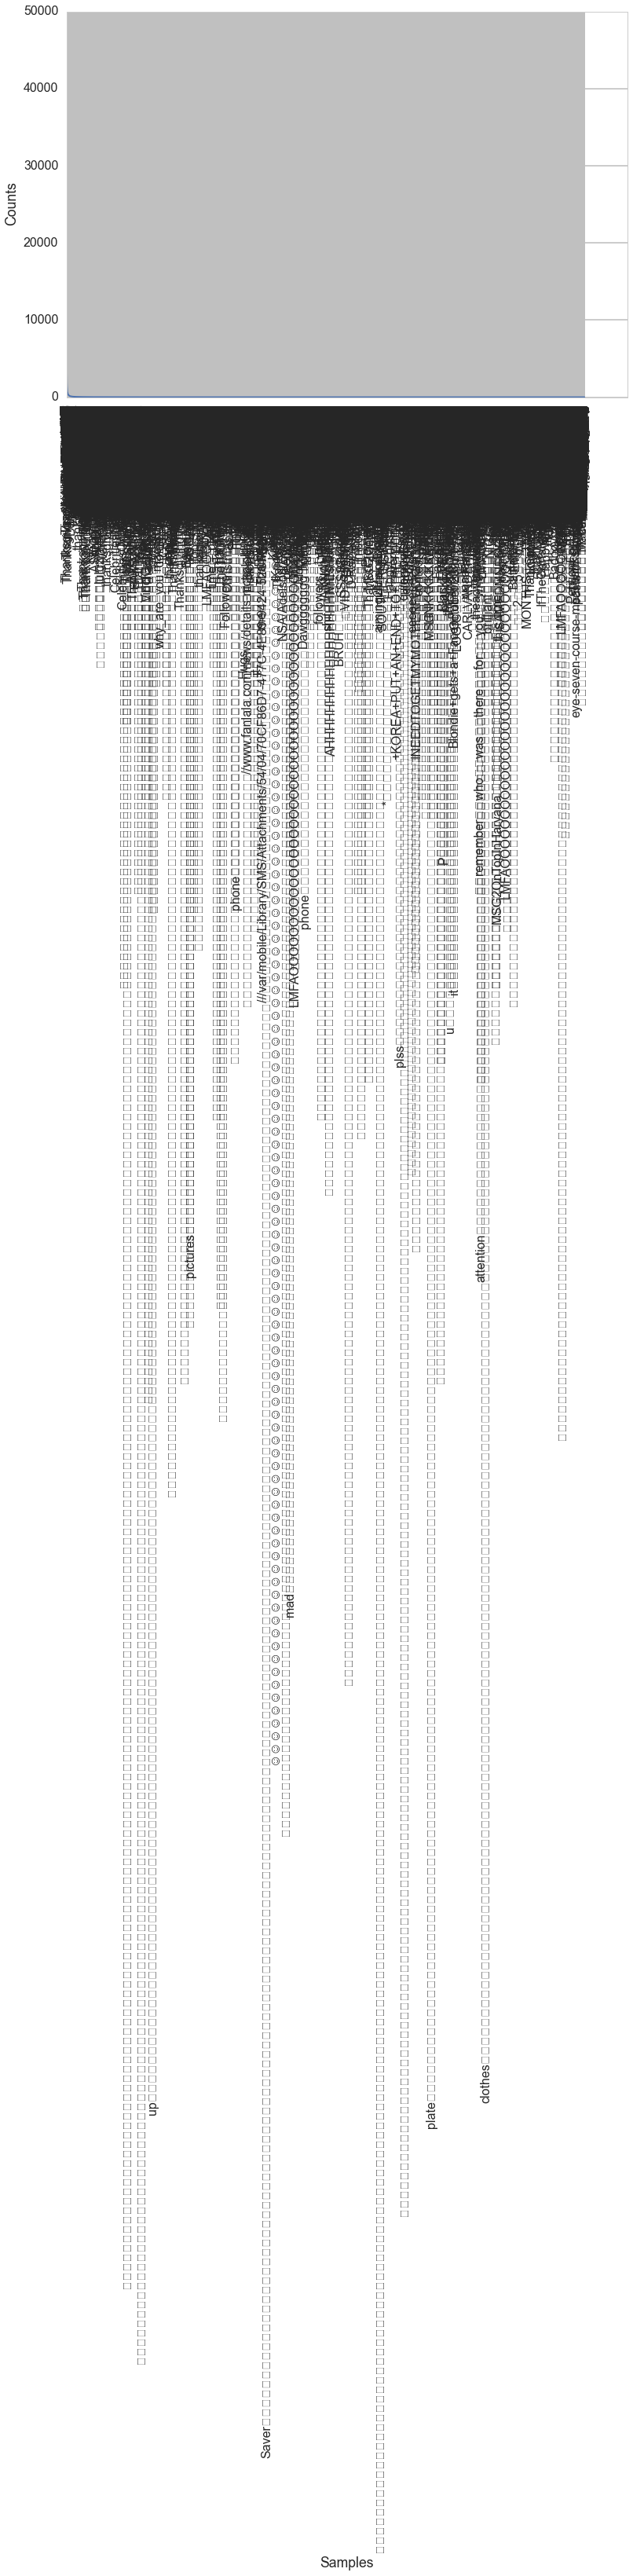

In [61]:
fdist.plot()

#### Visual content


#### Length of post

#### Controversy

### Prediction

In [19]:
import csv

# another example with Cursor get all tweets with a certain hashtag and a certain time frame within past week 
csvFile = open('tweets.csv', 'a')
#Use csv Writer
csvWriter = csv.writer(csvFile)

for tweet in tweepy.Cursor(api.search,q="#PrayForJapan",count=1,\
                           lang="en",\
                           since_id=2015-11-13).items():
    print tweet.created_at, tweet.text
    csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8')])

2015-11-14 05:41:34 RT @_MinaDaFly1D: Say no! Say no of the violence in the world! Go to love more 🙏🏻😱❤️ #PrayForJapan
2015-11-14 05:41:34 RT @GEO7GE: Seriously can't believe this has all happened in a day. #PrayForParis #PrayforBeirut #PrayforJapan https://t.co/CYCM2eViSI
2015-11-14 05:41:34 RT @Friendstagram: All we can do is PRAY 🙏🏼🌏

#PrayForParis 
#PrayForJapan
#PrayForLebanon 
#PrayForBaghdad 
#PrayForMexico https://t.co/K2…
2015-11-14 05:41:34 RT @CIothesPorn: My prayers go out to everyone 🙏🏼🙏🏼
#PrayForParis 
#PrayForJapan 
#PrayForLebanon 
#PrayForBaghdad 
#PrayForMexico https://…
2015-11-14 05:41:34 RT @loukeypookey: So sad that this all happened :(
#PrayForJapan
#PrayForLebanon
#PrayForBaghdad
#PrayForMexico
#PrayForParis https://t.co/…
2015-11-14 05:41:34 RT @justinbieburnt: Justin Bieber and his beliebers praying for Paris and Japan. #PrayForParis #PrayForJapan https://t.co/b2yNFYUSwS
2015-11-14 05:41:33 RT @zaynbaabe: Justin's album will still be there tomorrow but some li

TweepError: {"errors":[{"message":"Rate limit exceeded","code":88}]}